In [1]:
## Import libraries

In [2]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(scales)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
df_log <- read.csv(file = 'events.csv', sep = ',', stringsAsFactors = FALSE)
df_log$first_timestamp <- as.POSIXct(df_log$first_timestamp,format='%Y-%m-%dT%H:%M:%SZ', tzone = "UTC")
df_log$timestamp <- as.numeric(df_log$first_timestamp)

df_log <- df_log %>%
  group_by(uid) %>%
  mutate(min_timestamp = min(timestamp)) %>%
  ungroup()

df_activations <- read.csv(file = 'activations.csv', sep = ',', stringsAsFactors = FALSE)
summary(df_activations)

  object_uid        object_name        function_name         duration       
 Length:44          Length:44          Length:44          Min.   : 0.00470  
 Class :character   Class :character   Class :character   1st Qu.: 0.03089  
 Mode  :character   Mode  :character   Mode  :character   Median : 0.16505  
                                                          Mean   : 6.34628  
                                                          3rd Qu.: 3.95631  
                                                          Max.   :63.79308  
    reason            node         message       
 Length:44          Mode:logical   Mode:logical  
 Class :character   NA's:44        NA's:44       
 Mode  :character                                
                                                 
                                                 
                                                 

In [4]:
### Filter the events file

In [5]:
df_filtered <- df_log %>%
    filter(
      #reason == 'Scheduled' |
      reason == 'Pulling' |
      reason == 'Pulled' |
      reason == 'Created' |
      reason == 'Started' )

df_selected <- df_filtered %>%
    mutate(duration = abs(timestamp - min_timestamp)) %>%
    select(-name, -uid, -message, -min_timestamp, -first_timestamp, -last_timestamp, -timestamp)

summary(df_selected)

df_spread <- df_selected %>%
    group_by_at(vars(-duration)) %>%
    mutate(sample_id = row_number()) %>% ungroup() %>%
    spread(reason, duration) %>%
    select(-sample_id) #%>%
    #mutate(
    #    Created = replace_na(Created,0),
    #    Pulled = replace_na(Pulled,0),
    #    Pulling = replace_na(Pulling,0),
    #    Started = replace_na(Started,0))

df_processed <- df_spread %>%
    group_by(function_name) %>%
    mutate(
        container_image_downloading = abs(Pulled - Pulling),
        container_image_creation = abs(Created - Pulled),
        container_initialization = abs(Started - Created)) %>%
    mutate(
        Created = replace_na(container_image_downloading,0),
        Pulled = replace_na(container_image_creation,0),
        Pulling = replace_na(container_initialization,0)) %>%
    select(
        function_name,
        node,
        container_image_downloading,
        container_image_creation,
        container_initialization)

 function_name         reason              node              duration     
 Length:77          Length:77          Length:77          Min.   :  0.00  
 Class :character   Class :character   Class :character   1st Qu.:  1.00  
 Mode  :character   Mode  :character   Mode  :character   Median :  5.00  
                                                          Mean   : 16.84  
                                                          3rd Qu.:  8.00  
                                                          Max.   :396.00  

In [6]:
### Filter the activations file

'data.frame':	44 obs. of  5 variables:
 $ function_name: chr  "imageprocessing1" "imageprocessing1" "imageprocessing1" "videoprocessing1" ...
 $ duration     : num  0.0112 3.0532 0.1372 0.0449 63.0697 ...
 $ reason       : chr  "download_data" "function_execution" "upload_data" "download_data" ...
 $ node         : logi  NA NA NA NA NA NA ...
 $ object_uid   : chr  "e53696db46b14feeb696db46b18fee33" "e53696db46b14feeb696db46b18fee33" "e53696db46b14feeb696db46b18fee33" "430dbef73e2047828dbef73e203782a4" ...


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



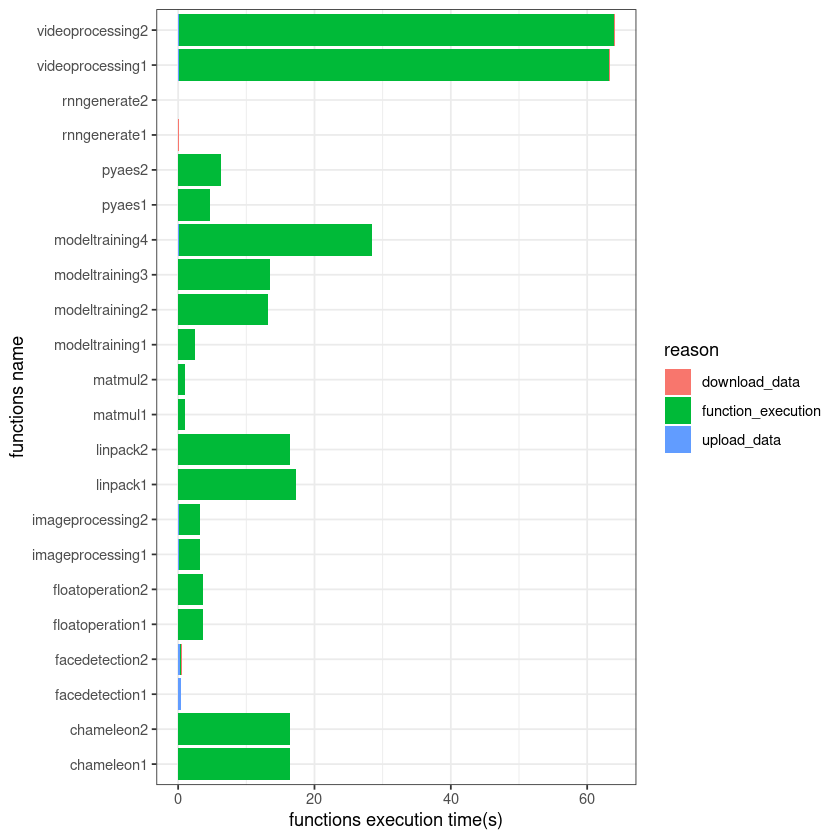

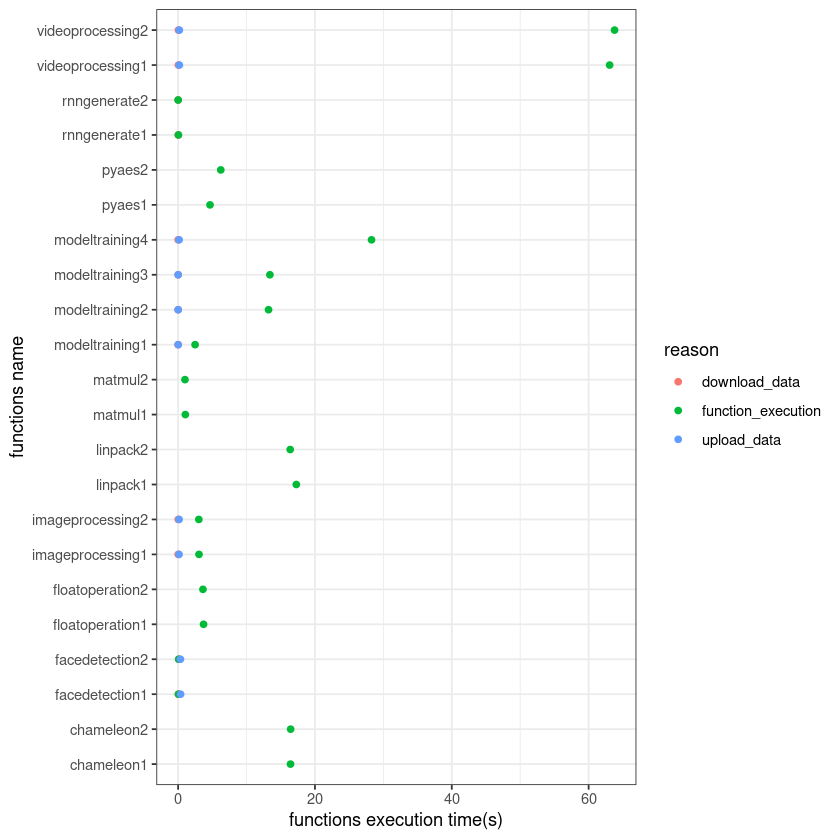

In [7]:
df_activations_selected <- df_activations %>%
    select(
        function_name,
        duration,
        reason,
        node,
        object_uid) #%>%
        #mutate(duration = (duration / 1000) %% 60)

str(df_activations_selected)
df_plot <- df_activations_selected

ggplot(data = df_plot) +
   geom_bar(aes(x = duration, y = function_name, fill = reason),stat='identity')  +
   labs(x = "functions execution time(s)", y = "functions name") +
   theme_bw() +
   ggsave('activations_bar_plot.png')

ggplot(data = df_plot) +
   geom_point(aes(x = duration, y = function_name, color = reason),stat='identity')  +
   labs(x = "functions execution time(s)", y = "functions name") +
   theme_bw() +
   ggsave('activations_point_plot.png')

In [8]:
### Spread the timestamps of activations by categories

In [9]:
head(df_activations)
df_activations_selected <- df_activations %>%
    select(
       #object_uid,
       function_name,
       duration,
       reason) #%>%
    #mutate(duration = (duration / 1000) %% 60)

df_spread_activations <- df_activations_selected %>%
   group_by_at(vars(-duration)) %>%
   mutate(sample_id = row_number()) %>% ungroup() %>%
   spread(reason, duration) %>%
   select(-sample_id)

head(df_spread_activations)
tail(df_spread_activations)

object_uid                       object_name      function_name   
1 e53696db46b14feeb696db46b18fee33 imageprocessing1 imageprocessing1
2 e53696db46b14feeb696db46b18fee33 imageprocessing1 imageprocessing1
3 e53696db46b14feeb696db46b18fee33 imageprocessing1 imageprocessing1
4 430dbef73e2047828dbef73e203782a4 videoprocessing1 videoprocessing1
5 430dbef73e2047828dbef73e203782a4 videoprocessing1 videoprocessing1
6 430dbef73e2047828dbef73e203782a4 videoprocessing1 videoprocessing1
  duration    reason             node message
1  0.01120472 download_data      NA   NA     
2  3.05322957 function_execution NA   NA     
3  0.13717747 upload_data        NA   NA     
4  0.04490924 download_data      NA   NA     
5 63.06966162 function_execution NA   NA     
6  0.18148923 upload_data        NA   NA

function_name   download_data function_execution upload_data
1 chameleon1              NA    16.43001175               NA  
2 chameleon2              NA    16.44617796               NA  
3 facedetection1  0.05174303     0.05174303        0.3659632  
4 facedetection2  0.09310913     0.09310913        0.3385849  
5 floatoperation1         NA     3.71962953               NA  
6 floatoperation2         NA     3.63316798               NA

function_name    download_data function_execution upload_data
1 pyaes1                   NA     4.666335106              NA  
2 pyaes2                   NA     6.233043194              NA  
3 rnngenerate1     0.03529310     0.043293715              NA  
4 rnngenerate2     0.01231503     0.007748842              NA  
5 videoprocessing1 0.04490924    63.069661617       0.1814892  
6 videoprocessing2 0.04519320    63.793084621       0.1821542

In [10]:
### Merge the activations and events data
library(stringr)

In [40]:
df_events_to_join <- df_processed #%>% mutate(id = row_number())
head(df_events_to_join)
df_activations_to_join <- df_spread_activations #%>% mutate(id = row_number())
head(df_activations_to_join)

df_all <- full_join(
   df_events_to_join,
   df_activations_to_join,
   by="function_name") #%>%
   #distinct()
df_all[is.na(df_all)] = 0

#head(df_all)

#df_renamed <- df_all %>%
#    group_by(object_uid) %>%
#    mutate(function_name = paste(function_name, '_', substr(object_uid, 1, 4))) %>%
#    ungroup() %>%
#    select(-object_uid)
#head(df_renamed)

df_gathered <- df_all %>%
    gather(
        factor_key = 'TRUE',
        key = 'reason',
        value = 'duration',
        -function_name, -node) 
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_image_downloading', '00_container_image_downloading')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_image_creation', '01_container_image_creation')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_initialization', '02_container_initialization')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'download_data', '03_download_data')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'function_execution', '04_function_execution')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'upload_data', '05_upload_data')

df_plot <- df_gathered
head(df_plot)
tail(df_plot)
#summary(df_plot)
#str(df_plot)

function_name   node         container_image_downloading
1 chameleon1      kind-worker2  6                         
2 chameleon2      kind-worker2 NA                         
3 facedetection1  kind-worker2  8                         
4 facedetection2  kind-worker3  7                         
5 floatoperation1 kind-worker2 20                         
6 floatoperation2 kind-worker3 19                         
  container_image_creation container_initialization
1 0                        0                       
2 0                        0                       
3 0                        0                       
4 0                        0                       
5 0                        0                       
6 1                        0

function_name   download_data function_execution upload_data
1 chameleon1              NA    16.43001175               NA  
2 chameleon2              NA    16.44617796               NA  
3 facedetection1  0.05174303     0.05174303        0.3659632  
4 facedetection2  0.09310913     0.09310913        0.3385849  
5 floatoperation1         NA     3.71962953               NA  
6 floatoperation2         NA     3.63316798               NA

function_name   node         reason                         duration
1 chameleon1      kind-worker2 00_container_image_downloading  6      
2 chameleon2      kind-worker2 00_container_image_downloading  0      
3 facedetection1  kind-worker2 00_container_image_downloading  8      
4 facedetection2  kind-worker3 00_container_image_downloading  7      
5 floatoperation1 kind-worker2 00_container_image_downloading 20      
6 floatoperation2 kind-worker3 00_container_image_downloading 19

function_name    node         reason         duration 
1 pyaes1           kind-worker2 05_upload_data 0.0000000
2 pyaes2           kind-worker2 05_upload_data 0.0000000
3 rnngenerate1     kind-worker3 05_upload_data 0.0000000
4 rnngenerate2     kind-worker2 05_upload_data 0.0000000
5 videoprocessing1 kind-worker2 05_upload_data 0.1814892
6 videoprocessing2 kind-worker3 05_upload_data 0.1821542

In [12]:
### Plot the merged data

Saving 6.67 x 6.67 in image



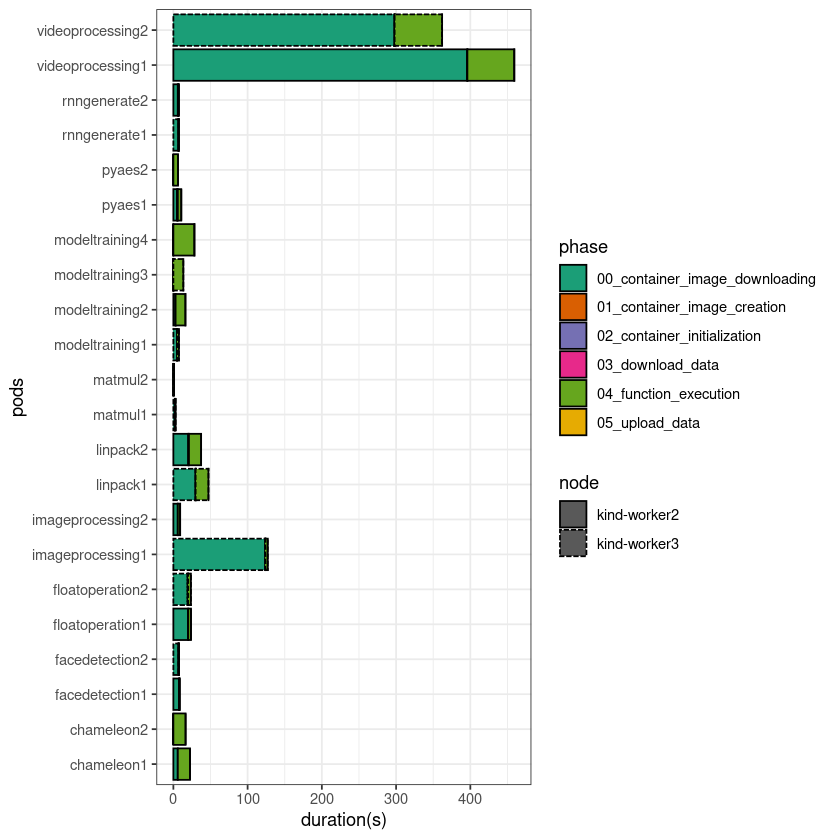

In [41]:
ggplot(data = df_plot, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack.png')

Saving 6.67 x 6.67 in image



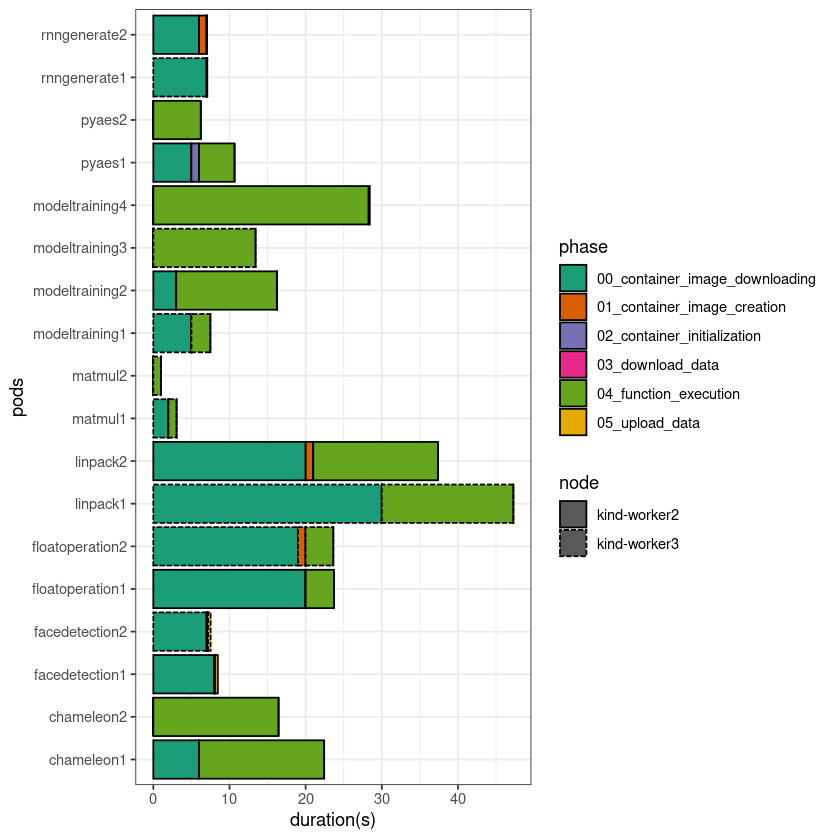

In [42]:
df_plot2 <- df_plot %>% filter(function_name != 'videoprocessing1' & function_name != 'videoprocessing2' &
                              function_name != 'imageprocessing1' & function_name != 'imageprocessing2')

ggplot(data = df_plot2, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack_filtered.png')

Saving 6.67 x 6.67 in image



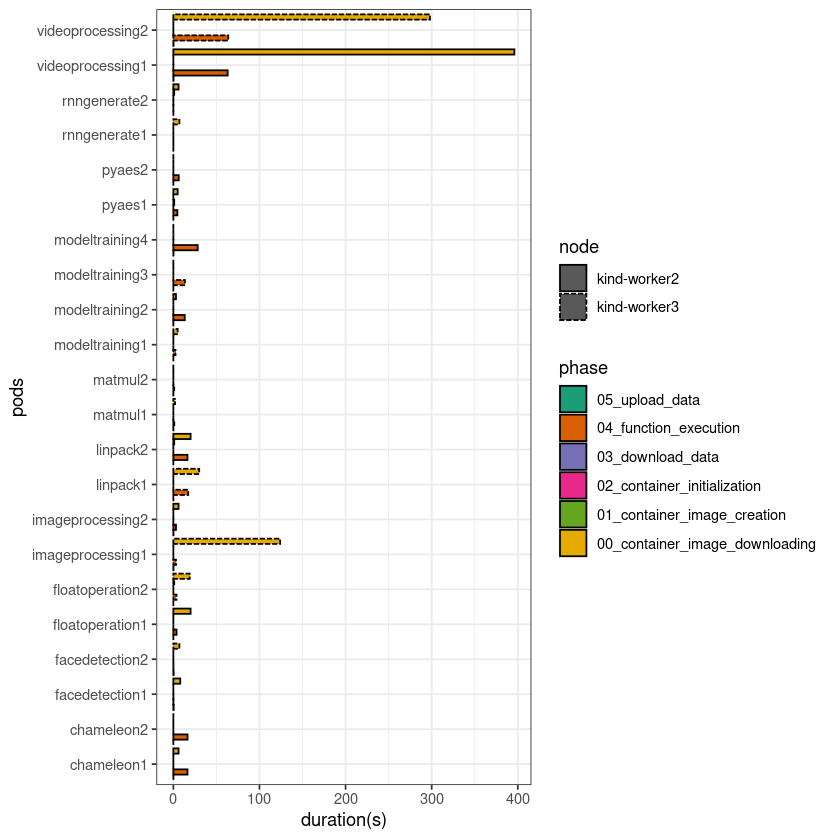

In [43]:
ggplot(data = df_plot, aes(x = duration, y = function_name, linetype = node,
                           fill = factor(reason, levels = rev(c("00_container_image_downloading",
                                  "01_container_image_creation", 
                                  "02_container_initialization", 
                                  "03_download_data", 
                                  "04_function_execution", 
                                  "05_upload_data"))))) +#, color = node)) +
   geom_bar(position="dodge", stat='identity', color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   theme_bw() +
   scale_fill_brewer(palette = "Dark2") +
   #guides(fill = guide_legend(reverse = TRUE))
   ggsave('full_bar_plot_dodge.png')

Saving 6.67 x 6.67 in image

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 71 rows containing missing values (geom_bar).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 71 rows containing missing values (geom_bar).”


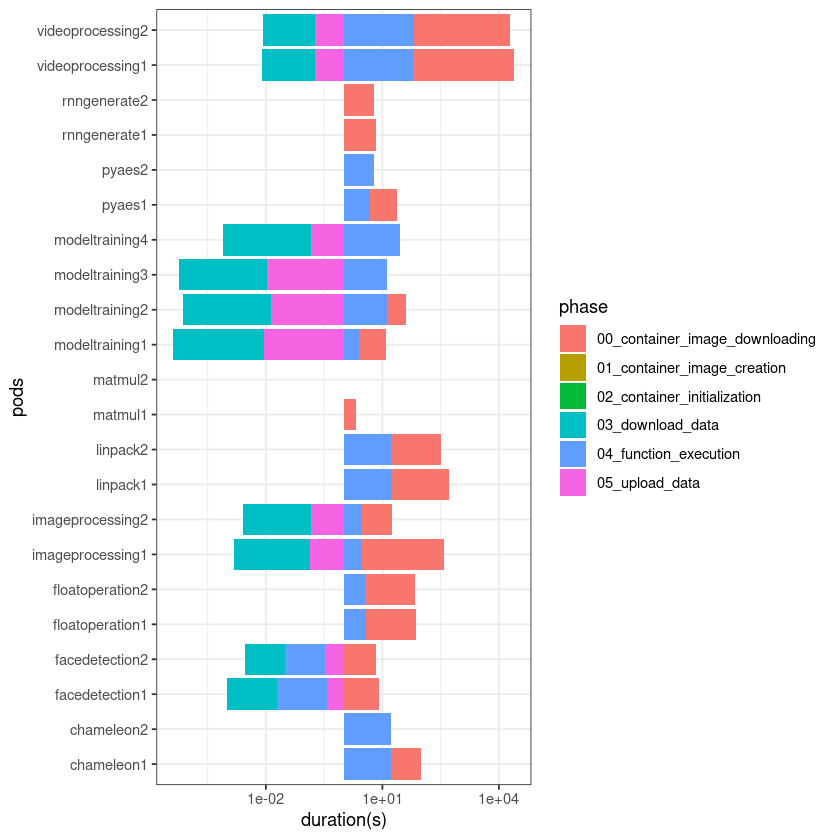

In [15]:
ggplot(data = df_plot, aes(x = duration, y = function_name, fill = reason))+#, color = node)) +
   geom_bar(stat='identity')  +
    scale_x_log10() +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   theme_bw() +
   ggsave('full_bar_plot_log10.png')

Saving 6.67 x 6.67 in image



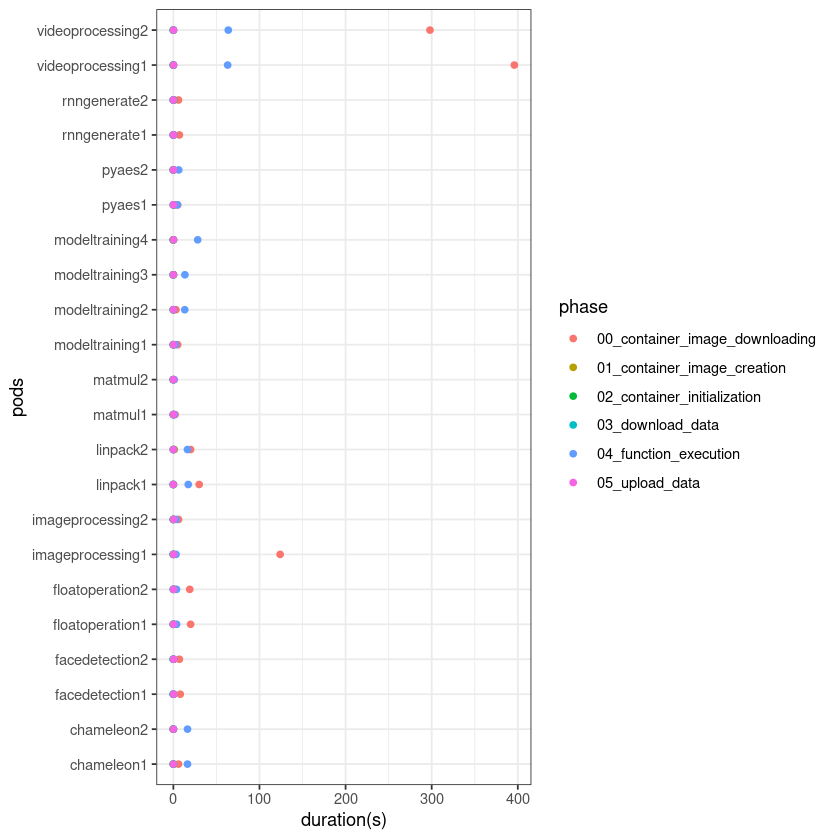

In [16]:
ggplot() +
    geom_point(data = df_plot, aes(x = duration, y = function_name, color = reason))+#, color = reason)) +
    labs(x = "duration(s)", y = "pods", color = "phase") +
    theme_bw() +
    ggsave('full_geom_point.png')

In [17]:
ggplot() +
    geom_point(data = df_plot, aes(x = duration, y = function_name, color = reason))+#, color = reason)) +
    labs(x = "duration(s) in log10", y = "pods", color = "phase") +
    scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    theme_bw() +
    ggsave('full_geom_point_log10.png')

Saving 6.67 x 6.67 in image

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
